In [1]:
import numpy as np 
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# CROP

In [33]:
crop = pd.read_csv('Data/crop_yield/Production_Crops_Livestock_E_All_Data_Normalized.csv',encoding='latin-1')
crop_flags = pd.read_csv('Data/crop_yield/Production_Crops_Livestock_E_Flags.csv',encoding='latin-1')

C:\Users\kina5\AppData\Local\Temp\ipykernel_23140\2876549892.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  crop = pd.read_csv('Data/crop_yield/Production_Crops_Livestock_E_All_Data_Normalized.csv',encoding='latin-1')


In [34]:
# To have the same years in the datasets, filter the datasets from year 1990
crop = crop[crop['Year']>=1990]

In [35]:
# Merge the main table (crop) with the meaning table of the column 'Flag'
crop = pd.merge(crop, crop_flags, on='Flag', how='right')
# Change the name to the new column
crop.rename(columns={'Description': 'Flag_description'}, inplace=True)

In [36]:
crop.head()

,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note,Flag_description
0,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1991,1991,ha,5500.0,A,NaN,Official figure
1,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1992,1992,ha,5500.0,A,NaN,Official figure
2,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1993,1993,ha,5500.0,A,NaN,Official figure
3,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1994,1994,ha,5500.0,A,NaN,Official figure
4,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1995,1995,ha,5500.0,A,NaN,Official figure


In [37]:
crop['Element'].unique()

array(['Area harvested', 'Yield', 'Production', 'Stocks', 'Prod Popultn',
       'Producing Animals/Slaughtered', 'Laying', 'Yield/Carcass Weight',
       'Milk Animals'], dtype=object)

In [38]:
# delete element types
delete_elements = ['Stocks', 'Laying', 'Milk Animals', 'Prod Popultn', 'Producing Animals/Slaughtered', 'Yield/Carcass Weight']

# Filter the DataFrame to exclude the rows with the specified elements, and keep area harvested, yield and production
crop = crop[~crop['Element'].isin(delete_elements)]

In [39]:
# Change the name to Elements type
crop['Element'] = crop['Element'].replace('Area harvested', 'area_harvested_ha')
crop['Element'] = crop['Element'].replace('Yield', 'Yield_hg/ha')
crop['Element'] = crop['Element'].replace('Production', 'production_tonnes')

In [40]:
# Delete innecessary columns
crop.drop(columns=['Area Code', 'Area Code (M49)','Item Code (CPC)','Element Code','Unit','Year Code','Note'], inplace=True)

In [11]:
crop.head()

,Area,Item Code,Item,Element,Year,Value,Flag,Flag_description
0,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1991,5500.0,A,Official figure
1,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1992,5500.0,A,Official figure
2,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1993,5500.0,A,Official figure
3,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1994,5500.0,A,Official figure
4,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1995,5500.0,A,Official figure


# PREC

In [2]:
prec = pd.read_csv('Data/TWB_avg_precip/0b1dbe54-6204-43c1-8bd8-dbbc6763a4dd_Series - Metadata.csv',encoding='latin-1') # Average precipitation in depth (mm per year)

In [3]:
# Delete innecessary columns
prec.drop(columns=['Series Name', 'Series Code','Country Code'], inplace=True)

In [4]:
# Change name columns
col = prec.columns
# Apply the regular expression using comprehension lists
years = [re.search(r'\d{4}', x).group() if re.search(r'\d{4}', x) else 'Area' for x in col]
# Change name columns with the new list years
prec.columns = years

In [5]:
prec.head()

,Area,1990,1991,1999,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,327,327,327,327,327,327,327,327,327,...,327,327,327,327,327,327,327,..,..,..
1,Albania,1485,1485,1485,1485,1485,1485,1485,1485,1485,...,1485,1485,1485,1485,1485,1485,1485,..,..,..
2,Algeria,89,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,..,..,..
3,American Samoa,..,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
4,Andorra,..,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..


In [6]:
prec.tail()

,Area,1990,1991,1999,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,Indicator Name,Source,Topic,Periodicity,Development relevance,Limitations and exceptions,License URL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,Average precipitation in depth (mm per year),"Food and Agriculture Organization, electronic ...",Environment: Land use,Annual,The agriculture sector is the most water-inten...,The data are collected by the Food and Agricul...,https://datacatalog.worldbank.org/public-licen...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# delete the last two rows
prec = prec.iloc[:-2]

There are a lot of nan in the back rows, this will be addressed in the preprocessing section.

In [8]:
prec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Area    266 non-null    object
 1   1990    266 non-null    object
 2   1991    266 non-null    object
 3   1999    266 non-null    object
 4   2000    266 non-null    object
 5   2001    266 non-null    object
 6   2002    266 non-null    object
 7   2003    266 non-null    object
 8   2004    266 non-null    object
 9   2005    266 non-null    object
 10  2006    266 non-null    object
 11  2007    266 non-null    object
 12  2014    266 non-null    object
 13  2015    266 non-null    object
 14  2016    266 non-null    object
 15  2017    266 non-null    object
 16  2018    266 non-null    object
 17  2019    266 non-null    object
 18  2020    266 non-null    object
 19  2021    266 non-null    object
 20  2022    266 non-null    object
 21  2023    266 non-null    object
dtypes: object(22)
memory usage

- PREPROCESSING

NaN values

In [10]:
# replace .. by NaN
prec.replace('..', np.nan, inplace=True)

<Axes: >

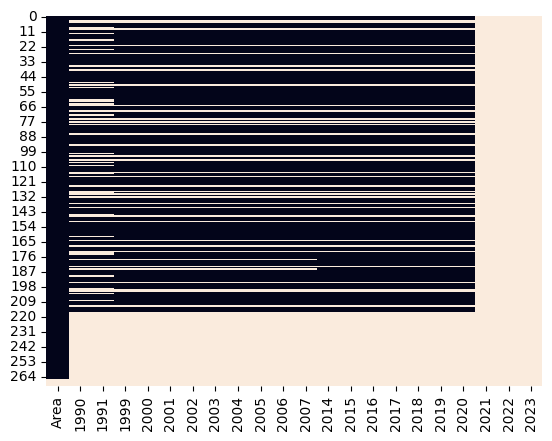

In [11]:
sns.heatmap(prec.isnull(), cbar=False) # Vemos los nulos con un gráfico heatmap

In [12]:
# percentage of nan values (columns)
prec.isnull().sum() / len(prec) * 100

Area      1.845018
1990     42.066421
1991     42.066421
1999     33.579336
2000     33.579336
2001     33.579336
2002     33.579336
2003     33.579336
2004     33.579336
2005     33.579336
2006     33.579336
2007     33.579336
2014     32.841328
2015     32.841328
2016     32.841328
2017     32.841328
2018     32.841328
2019     32.841328
2020     32.841328
2021    100.000000
2022    100.000000
2023    100.000000
dtype: float64

In [13]:
# percentage of nan values (rows)
prec.isnull().sum(axis=1) / prec.shape[1] * 100

0       13.636364
1       13.636364
2       13.636364
3       95.454545
4       95.454545
          ...    
266    100.000000
267    100.000000
268    100.000000
269    100.000000
270    100.000000
Length: 271, dtype: float64

In [15]:
# # Calculate the percentage of null values in each row
percent_missing_rows = prec.isnull().sum(axis=1) / prec.shape[1] * 100

# Filter out rows with a percentage of nulls = 100
missing_rows = percent_missing_rows[percent_missing_rows==100].index

# Display rows with a percentage of nulls = 100
prec.loc[missing_rows]

# delete missing_rows
prec.drop(missing_rows, inplace=True)

In [17]:
# no information of the columns 2021, 2022, 2023. Delete

prec.drop(columns=['2021', '2022','2023'], inplace=True)

In [18]:
# percentage of nan values (columns)
prec.isnull().sum() / len(prec) * 100

Area     0.000000
1990    40.977444
1991    40.977444
1999    32.330827
2000    32.330827
2001    32.330827
2002    32.330827
2003    32.330827
2004    32.330827
2005    32.330827
2006    32.330827
2007    32.330827
2014    31.578947
2015    31.578947
2016    31.578947
2017    31.578947
2018    31.578947
2019    31.578947
2020    31.578947
dtype: float64

In [19]:
prec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Area    266 non-null    object
 1   1990    157 non-null    object
 2   1991    157 non-null    object
 3   1999    180 non-null    object
 4   2000    180 non-null    object
 5   2001    180 non-null    object
 6   2002    180 non-null    object
 7   2003    180 non-null    object
 8   2004    180 non-null    object
 9   2005    180 non-null    object
 10  2006    180 non-null    object
 11  2007    180 non-null    object
 12  2014    182 non-null    object
 13  2015    182 non-null    object
 14  2016    182 non-null    object
 15  2017    182 non-null    object
 16  2018    182 non-null    object
 17  2019    182 non-null    object
 18  2020    182 non-null    object
dtypes: object(19)
memory usage: 39.6+ KB


In [20]:
prec.columns

Index(['Area', '1990', '1991', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020'],
      dtype='object')

In [21]:
# Change the number columns type to float
year_col = ['1990', '1991', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020']
prec[year_col]= prec[year_col].astype(float)

As the rainfall values are mm per year and they are continuous variables, we will do the imputation with the mean value of mm per year:

In [22]:
def repair_null(df, col):
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df 

for col in prec.columns:
    repair_null(prec, col)

prec.isnull().sum()/len(prec)*100

Area    0.0
1990    0.0
1991    0.0
1999    0.0
2000    0.0
2001    0.0
2002    0.0
2003    0.0
2004    0.0
2005    0.0
2006    0.0
2007    0.0
2014    0.0
2015    0.0
2016    0.0
2017    0.0
2018    0.0
2019    0.0
2020    0.0
dtype: float64

In [28]:
# calculation of the average rainfall from 1990-present in a new column

prec['average_1990_2020'] = prec[year_col].mean(axis=1).round(2)

In [31]:
# create a new df with Area and average columns
prec_filtered = prec[['Area','average_1990_2020']].copy()
prec_filtered

,Area,average_1990_2020
0,Afghanistan,327.00
1,Albania,1485.00
2,Algeria,89.00
3,American Samoa,1183.25
4,Andorra,1183.25
...,...,...
261,Sub-Saharan Africa,1183.25
262,Sub-Saharan Africa (excluding high income),1183.25
263,Sub-Saharan Africa (IDA & IBRD countries),1183.25
264,Upper middle income,1183.25


# PEST

In [56]:
pest = pd.read_csv('Data/pesticides_use/Inputs_Pesticides_Use_E_All_Data_(Normalized).csv',encoding='latin-1')

C:\Users\kina5\AppData\Local\Temp\ipykernel_23140\1858708548.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  pest = pd.read_csv('Data/pesticides_use/Inputs_Pesticides_Use_E_All_Data_(Normalized).csv',encoding='latin-1')


In [59]:
# To have the same years in the datasets, filter the datasets from year 1990
pest = pest[pest['Year']>=1990]

In [ ]:
pest.head()

In [78]:
pest['Element'].unique()

array(['Agricultural Use', 'Use per area of cropland', 'Use per capita',
       'Use per value of agricultural production'], dtype=object)

In [79]:
pest[pest['Element']=='Use per area of cropland']

,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note,Flag_description
34562,3,'008,Albania,1357,Pesticides (total),5159,Use per area of cropland,1990,1990,kg/ha,0.17,E,NaN,Estimated value
34563,3,'008,Albania,1357,Pesticides (total),5159,Use per area of cropland,1991,1991,kg/ha,0.17,E,NaN,Estimated value
34564,3,'008,Albania,1357,Pesticides (total),5159,Use per area of cropland,1992,1992,kg/ha,0.17,E,NaN,Estimated value
34565,3,'008,Albania,1357,Pesticides (total),5159,Use per area of cropland,1993,1993,kg/ha,0.17,E,NaN,Estimated value
34566,3,'008,Albania,1357,Pesticides (total),5159,Use per area of cropland,1994,1994,kg/ha,0.29,E,NaN,Estimated value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103463,91,'328,Guyana,1357,Pesticides (total),5159,Use per area of cropland,2017,2017,kg/ha,1.19,I,NaN,Imputed value
103464,91,'328,Guyana,1357,Pesticides (total),5159,Use per area of cropland,2018,2018,kg/ha,1.29,I,NaN,Imputed value
103465,91,'328,Guyana,1357,Pesticides (total),5159,Use per area of cropland,2019,2019,kg/ha,1.57,I,NaN,Imputed value
103466,91,'328,Guyana,1357,Pesticides (total),5159,Use per area of cropland,2020,2020,kg/ha,2.03,I,NaN,Imputed value


In [ ]:
# delete element types
delete_elements = ['Use per capita','Use per value of agricultural production']

# Filter the DataFrame to exclude the rows with the specified elements, and keep production, agricultural use and Use per area of cropland
pest = pest[~pest['Element'].isin(delete_elements)]
# Change the name to Elements type
pest['Element'] = pest['Element'].replace('Agricultural Use', 'agricultural use_tonnes')
pest['Element'] = pest['Element'].replace('Use per area of cropland', 'use per area_kg/ha')

In [60]:
pest.head()

,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1990,1990,t,121.0,E,NaN
1,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1991,1991,t,121.0,E,NaN
2,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1992,1992,t,121.0,E,NaN
3,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1993,1993,t,121.0,E,NaN
4,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1994,1994,t,201.0,E,NaN


In [64]:
# create new filtered df
pest_filtered = fert[['Area','Item','Element','Year','Value']].copy()
# Change the name to the new column
pest_filtered.rename(columns={'Item': 'pesticides_type'}, inplace=True)

# FERT

In [65]:
fert = pd.read_csv('Data/fertilizers/Inputs_FertilizersNutrient_E_All_Data_Normalized.csv',encoding='latin-1')

C:\Users\kina5\AppData\Local\Temp\ipykernel_23140\3626790460.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  fert = pd.read_csv('Data/fertilizers/Inputs_FertilizersNutrient_E_All_Data_Normalized.csv',encoding='latin-1')


In [66]:
# To have the same years in the datasets, filter the datasets from year 1990
fert_filtered = fert[fert['Year']>=1990]

In [67]:
fert.head()

,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1974,1974,t,19117.0,A,Official data from questionnaire
1,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1975,1975,t,14774.0,A,Official data from questionnaire
2,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1976,1976,t,26203.0,A,Official data from questionnaire
3,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1977,1977,t,37689.0,A,Official data from questionnaire
4,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1978,1978,t,48300.0,A,Official data from questionnaire


In [71]:
fert['Element'].unique()

array(['Production', 'Import Quantity', 'Export Quantity',
       'Agricultural Use', 'Use per area of cropland', 'Use per capita',
       'Use per value of agricultural production'], dtype=object)

In [76]:
# delete element types
delete_elements = ['Import Quantity', 'Export Quantity', 'Use per capita','Use per value of agricultural production']

# Filter the DataFrame to exclude the rows with the specified elements, and keep production, agricultural use and Use per area of cropland
fert = fert[~fert['Element'].isin(delete_elements)]
# Change the name to Elements type
fert['Element'] = fert['Element'].replace('Production', 'production_tonnes')
fert['Element'] = fert['Element'].replace('Agricultural Use', 'agricultural use_tonnes')
fert['Element'] = fert['Element'].replace('Use per area of cropland', 'use per area_kg/ha')

In [77]:
fert.head()

,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note,Flag_description
0,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,production_tonnes,1974,1974,t,19117.0,A,Official data from questionnaire,Official figure
1,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,production_tonnes,1975,1975,t,14774.0,A,Official data from questionnaire,Official figure
2,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,production_tonnes,1976,1976,t,26203.0,A,Official data from questionnaire,Official figure
3,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,production_tonnes,1977,1977,t,37689.0,A,Official data from questionnaire,Official figure
4,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,production_tonnes,1978,1978,t,48300.0,A,Official data from questionnaire,Official figure


In [ ]:
# create new filtered df
fert_filtered = fert[['Area','Item','Element','Year','Value']].copy()
# Change the name to the new column
fert_filtered.rename(columns={'Item': 'fertilizer_type'}, inplace=True)

# TEMP

In [ ]:
# Data: https://tradingeconomics.com/country-list/temperature




# Merge crop & prec_filtered

In [41]:
crop.shape

(1957849, 8)

In [55]:
crop['Area'].nunique()

245

In [43]:
crop.head(2)

,Area,Item Code,Item,Element,Year,Value,Flag,Flag_description
0,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1991,5500.0,A,Official figure
1,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1992,5500.0,A,Official figure


In [42]:
prec_filtered.shape

(266, 2)

In [50]:
prec_filtered['Area'].nunique()

266

In [45]:
prec_filtered.head(2)

,Area,average_1990_2020
0,Afghanistan,327.0
1,Albania,1485.0


There are more countries in the df prec_filtered. Let's merge them and use an inner join so that only rows that have matches in both tables are included in the column you use to join. Rows that do not have matches in both tables will not be included in the resulting DataFrame.

In [51]:
df = crop.merge(prec_filtered, on='Area', how='inner')

In [53]:
df['Area'].nunique()

168